# TP1 - Compressão e Descompressão de Imagem

### Alunos:

Vinicius Silva Gomes - 2021421869

João Antonio Oliveira Pedrosa - 2019006752

In [1]:
# Library import

%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# Variables and auxiliar functions

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

def compression_rate(original_image, compressed_image):
    original_image_size = os.stat('source.jpg').st_size
    compressed_image_size = os.stat('compressed.jpg').st_size
    
    return original_image_size/compressed_image_size

SQ = 8

# Default quantization matrix implemented by JPEG compression method
quant_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                        [12, 12, 14, 19, 26, 58, 60, 55],
                        [14, 13, 16, 24, 40, 57, 69, 56],
                        [14, 17, 22, 29, 51, 87, 80, 62],
                        [18, 22, 37, 56, 68, 109, 103, 77],
                        [24, 35, 55, 64, 81, 104, 113, 92],
                        [49, 64, 78, 87, 103, 121, 120, 101],
                        [72, 92, 95, 98, 112, 100, 103, 99]])

Dimensões da imagem: 512x512
Tamanho da imagem (em disco): 0.262178 MB / 262.178 kB


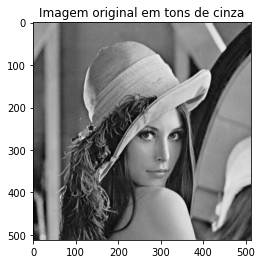

In [3]:
# Importação da imagem sem compressão e informações relevantes sobre ela

src_img = cv2.imread('lena512.pgm', 0)
src_img_size = os.stat('lena512.pgm').st_size

print("Dimensões da imagem: {}x{}".format(src_img.shape[1], src_img.shape[0]))
print("Tamanho da imagem (em disco): {} MB / {} kB".format(src_img_size/10 ** 6, src_img_size/10 ** 3))

plt.title("Imagem original em tons de cinza")
plt.imshow(src_img, cmap="gray")

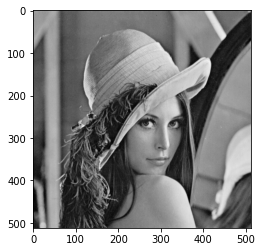

In [4]:
# Padding image

img_shape = src_img.shape

lin    = img_shape[0]
col    = img_shape[1]

xpad   = (SQ - lin % SQ) % SQ
ypad   = (SQ - col % SQ) % SQ

padded_img = src_img
padded_img = np.append(padded_img, np.full((xpad, col)        , 255), axis = 0)
padded_img = np.append(padded_img, np.full((lin + xpad, ypad) , 255), axis = 1)

plt.imshow(padded_img, cmap="gray")

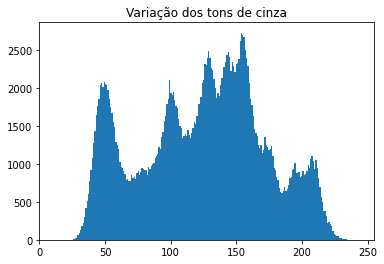

In [5]:
# Histograma com os níveis de cinza da imagem

flattered_img = padded_img.ravel()

plt.hist(flattered_img, 256, [0,255]);
plt.xlim([0, 255])
plt.title("Variação dos tons de cinza")
plt.show()

In [7]:
# Function that receives a SQ x SQ block and applies DCT Transform + Quantization

def apply_dct(image):
    image -= 128
    image =  image.astype(float)
    return cv2.dct(image)

def apply_idct(image):
    image =  image.astype(float)
    image = cv2.idct(image)
    image += 128
    return image

def simplify(block):
    local_dct        = apply_dct(block)
    local_quant      = local_dct / quant_matrix
    local_quant      = local_quant.round()
    # Huffman Encoding
    # Aqui a gente salva!
    # Huffman Decoding
    local_simplified = apply_idct(local_quant * quant_matrix)
    
    return local_simplified

In [7]:
12 12 4

2 8 4
3 7
3 4 5 7
1 7
2 4 5 
2 7 8

SyntaxError: invalid syntax (365899389.py, line 1)

In [ ]:
np.save()

RMSE: 4.133250767135528
PSNR: 35.80496850822563


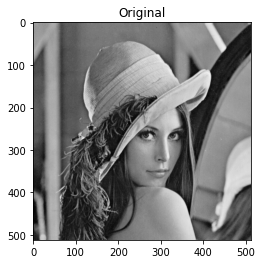

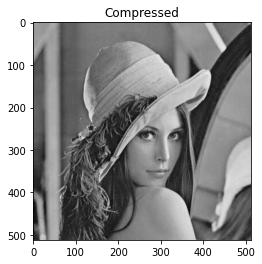

In [8]:
# Iterating
padded_img_shape = padded_img.shape

lin = padded_img_shape[0]
col = padded_img_shape[1]

dct_full = np.zeros(padded_img_shape)

for l in range(0, lin, SQ):
    for c in range(0, col, SQ):
        dct_full[l:l+SQ, c:c+SQ] = simplify(padded_img[l:l+SQ, c:c+SQ].copy())

plt.title("Original")
plt.imshow(padded_img, cmap="gray",)
plt.figure()

plt.title("Compressed")
plt.imshow(dct_full, cmap="gray")

print("RMSE:", rmse(padded_img, dct_full))
print("PSNR:", psnr(padded_img, dct_full))
# print("Taxa de Compressão:", compression_rate(padded_img, dct_full))

In [32]:
# Saving
cv2.imwrite("results/original.png", padded)
cv2.imwrite("results/compressed.png", dct_full)

True

In [29]:
from heapq import heappush, heappop, heapify
from collections import defaultdict

# quantization = 4

def preditive_encode(img):
    preditive = img.copy()
    
    for i in range(0, lin):
        for j in range(0, col):
            if(j != 0):
                preditive[i, j] -= preditive[i, j - 1]
                
    return preditive

def encode(symb2freq):
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

def huffman_encode(matrix):
    hist = cv2.calcHist([matrix.astype('uint8')], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()

    symb2freq = defaultdict(float)

    for i in range(0,256):
        symb2freq[i] = hist[i]

    huff = encode(symb2freq)
    huff_dict = {}

    for i in range(0, len(huff)):
        huff_dict[huff[i][0]] = huff[i][1]
        
    return huff_dict

preditive_matrix = preditive_encode(padded_img)                                    
huffman = huffman_encode(preditive_matrix)
    
print(huff_dict)

{0: '0101011', 2: '0000010', 4: '0000000', 254: '0001010', 255: '0000100', 1: '11110101', 3: '11111100', 5: '11111110', 6: '11011001', 7: '11110111', 8: '11101101', 9: '11111010', 10: '11100010', 11: '11000011', 12: '11110001', 13: '11100100', 14: '10101101', 15: '11010100', 16: '10111100', 17: '11011010', 18: '11011011', 19: '11100101', 20: '11100110', 21: '11000101', 22: '10000101', 23: '11001001', 24: '10111101', 25: '10101110', 26: '11001011', 27: '10000011', 28: '10100010', 29: '10000001', 30: '11000100', 31: '10111001', 32: '10011111', 33: '10010000', 34: '10001011', 35: '01101100', 36: '11010110', 37: '10011000', 38: '10010111', 39: '01111000', 40: '10011110', 41: '10100000', 42: '10101111', 43: '11101010', 44: '11000110', 45: '10100111', 46: '11010000', 47: '11110010', 48: '11010010', 49: '11110011', 50: '11010011', 51: '10001111', 52: '10010001', 53: '11010111', 54: '11001101', 55: '10101011', 56: '10111010', 57: '10001010', 58: '10010101', 59: '10011010', 60: '11011100', 61: 